In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.tree import DecisionTreeClassifier
from sklearn import datasets

In [2]:
iris = datasets.load_iris()
y = (iris.target != 0) * -1
y[y ==0] = 1
iris_data = pd.DataFrame(data = iris.data[:,0:2], columns = ["Sepal Length (cm)", "Sepal Width (cm)"])
iris_target = pd.DataFrame(data = y, columns = ["target"])
iris_df = pd.concat([iris_data, iris_target], axis = 1)

X = iris.data[:, :2]
#training and testing set size
train_size=int(0.75*iris_df.shape[0])
test_size=int(0.25*iris_df.shape[0])

print("Training set size : "+ str(train_size))
print("Testing set size : "+str(test_size))

#Getting features from dataset
Data=iris_df.sample(frac=1)
X=Data.iloc[:,[0, 1]].values
y=Data.iloc[:,2].values

#training set split
X_train=X[0:train_size,:]
y_train=y[0:train_size]

#testing set split
X_test=X[train_size:,:]
y_test=y[train_size:]

Training set size : 112
Testing set size : 37


In [3]:
class AdaBoost():
    def __init__(self, iters=10, learning_rate=1):
        self.learning_rate = learning_rate
        self.iters = iters
        self.estimators = []
        self.y_preds = []
        self.estimators_weight = []
    
    def fit(self, X_train, y_train):
        sample_weight = np.ones(len(y_train))/len(y_train)
        for _ in range(self.iters):   
            #DecisionTreeClassifier classifier
            estimator = DecisionTreeClassifier(max_depth = 1, max_leaf_nodes=2)
            estimator.fit(X_train, y_train, sample_weight=sample_weight)
            y_predict = estimator.predict(X_train)
            self.estimators.append(estimator)

            estimator_error = ((y_predict != y_train).dot(sample_weight))/sum(sample_weight)
            estimator_weight =  self.learning_rate * np.log((1 - estimator_error)/estimator_error)
            #New sample weights
            sample_weight *= np.exp(estimator_weight * (y_predict != y_train))

            self.estimators_weight.append(estimator_weight.copy())   
            
    def prediction(self,X_test):
        
        for est in self.estimators:   
            y_predict = est.predict(X_test)
            self.y_preds.append(y_predict.copy())
            
        return ([np.sign((np.array(self.y_preds)[:,point] * self.estimators_weight).sum())\
                                                                     for point in range(len(X_test))])
    def get_estimators(self):
        return self.estimators
    
    def get_estimators_weight(self):
        return self.estimators_weight

In [4]:
ada = AdaBoost()
ada.fit(X_train,y_train)
prediction = ada.prediction(X_test)

In [5]:
def AdaBoost_boundary(estimators, estimators_weight, X, y, N=10, ax=None):
    
    def AdaBoost_classify(x_temp, est, est_weights):
        temp_pred = np.asarray([(e.predict(x_temp)).T* w for e, w in zip(est,est_weights)])/est_weights.sum()
        return np.sign(temp_pred.sum(axis = 0))
    
    x_min, x_max = X[:, 0].min() - 0.25, X[:, 0].max() + 0.25
    y_min, y_max = X[:, 1].min() - 0.25, X[:, 1].max() + 0.25
    
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, N), np.linspace(y_min, y_max, N))
    zz = np.array([AdaBoost_classify(np.array([xi,yi]).reshape(1,-1), estimators,estimators_weight)\
                                                        for xi, yi in zip(np.ravel(xx), np.ravel(yy))])
    Z = zz.reshape(xx.shape)

    ax = plt.gca()
    ax.contourf(xx, yy, Z, 2, cmap = 'CMRmap_r', alpha = 0.5)
    ax.scatter(X[:,0], X[:,1], c = y)
    ax.set_xlabel('$X_1$')
    ax.set_ylabel('$X_2$')

Accuracy =  0.9736842105263158


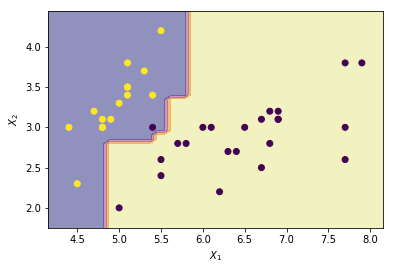

In [6]:
AdaBoost_boundary(ada.get_estimators(), np.array(ada.get_estimators_weight()), X_test, y_test, N = 50)
print('Accuracy = ', (np.array(prediction) == y_test).sum()/len(y_test)) 